In [453]:
# arima_module importation #

from crypto_module import *

# **Third Model : ARIMA model**

### **I-Introduction**

**ARIMA** stands for **Auto-Regressive Integrated Moving Average** and is a product of two models : 

- **Auto-Regressive model (AR)** parametized by a value p, which allows to predict the future value of a time series through a regression on its last p values.

- **Moving Average model (MA)** parametized by a value q, which instead of using past forecast values uses past forecast errors in a regression-like model and aim to improve the model's forecasts by knowing how far off our prediction from yesterday was compared to the actual value. The forcasts are made based on the last q periods before the current period.


**ARIMA** model have a last parameter, the order of differenciation d, which is the number of times we must differenciate the time series to make it stationnary. **Stationnary is a must-have feature** in our time series that allows us to apply the two components (AR, MA) of the ARIMA model.


To sum up, we aim to predict the close cotation by using an **ARIMA(p,d,q)** model. From now on, we focus on the determination of the parameters **p,d,q**.

### **II-Loading and visualizing the data**

In [484]:
# Use the API to load the data #

symbol = 'BTC/USD'
interval = '1day'
start_date = '2015-01-01 00:00:00'
end_date = '2015-12-31 00:00:00'

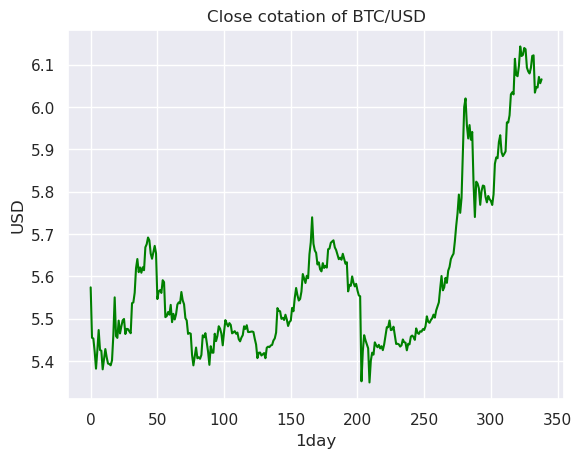

In [485]:
# Fast checking the data values #

data = load_data(symbol, start_date, end_date, interval)


def add_arima_indicators(data,price, period, ln = False) : 
    
    
    if ln == True :
    
        for i in data.columns[1:] :

            data[str(i)] = np.log(data[str(i)])


    ma = data[str(price)].rolling(window=period).mean().dropna()
    mstd = data[str(price)].rolling(window=period).std().dropna()
    data = pd.DataFrame(data.loc[period-1:])

    data['ma'] = ma
    data['mstd'] = mstd
    
    return data.reset_index().drop('index', axis=1)

data = add_arima_indicators(data, "close", period = 14) 

log_data = add_arima_indicators(data, "close", period = 14, ln = True)

data.head(n = 10)


visualize_data(log_data, symbol, interval)

In [486]:
#We can visualize the data along with its moving statistics. A  stationnary time series must have these features constants in time #


def arima_viz_with_indicator(data, symbol, interval) :

    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=['Candles', 'Moving Average', 'Moving Std'])
    candle = go.Candlestick(x=data['datetime'],
                                        open=data['open'],
                                        high=data['high'],
                                        low=data['low'],
                                        close=data['close'], 
                                        name = "Cotation")

    fig.add_trace(candle, row=1, col =1)


    ma_trace=go.Scatter(x=data['datetime'], y=data['ma'], mode='lines', name="Moving Average", yaxis='y2')

    fig.add_trace(ma_trace, row=2, col=1)

    mstd_trace=go.Scatter(x=data['datetime'], y=data['mstd'], mode='lines', name="Moving Std", yaxis='y3')

    fig.add_trace(mstd_trace, row=3, col=1)

    
    fig.update_layout(title='Cotation of ' + str(symbol) + ' per ' + str(interval) ,
                  xaxis_title='Date',
                  yaxis_title='Price in USD',
                  xaxis_rangeslider_visible=False)



    fig.show()

arima_viz_with_indicator(data,symbol, interval)

We will apply logarithmic transformation to the data in order to reduce the variation strength.

In [487]:
arima_viz_with_indicator(log_data, symbol, interval)

### **III-Stationnarity test**

We observed a downward trend and a non-constant variance in the previous plots. Our series is far from stationnary

Two tests can help us confirm wether the series is stationnary or not :

- The **Augmented Dicky Fuller Test (ADF Test)** : H0 = The series is non-stationary. The more negative the ADF number is, the more prominent the rejection of the null hypothesis that the time series is non-stationary.

- The **Kwiatkowski–Phillips–Schmidt–Shin (KPSS)**: H0 = The series is stationary. The higher the test statistic, the more prominent the rejection of the null hypothesis that the series is stationary.


Let's perform an example on the original series.

In [488]:
def adf_test(data, price, to_print = True) : 
    result = adfuller(data[str(price)])
    adf_stat = result[0]
    p_value = result[1]

    if to_print == True : 

        print('ADF statistic : %f' % adf_stat)
        print('p-value : %f' % p_value)

    else :
        
        return adf_stat, p_value





def kpss_test(data, price, to_print = True) : 

    
    kpsstest = kpss(data[str(price)], regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:2], index=["Test Statistic", "p-value"]
    )
    if to_print == True :
        
        print("Results of KPSS Test:")
        print(kpss_output)

    else :
        
        return kpss_output

adf_test(data, "close")
kpss_test(data, 'close')

ADF statistic : -0.991948
p-value : 0.756190
Results of KPSS Test:
Test Statistic    0.385085
p-value           0.010000
dtype: float64


/tmp/ipykernel_173083/2006278047.py:22: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [489]:
adf_test(log_data, "close")
kpss_test(log_data, "close")

ADF statistic : -0.687139
p-value : 0.850053
Results of KPSS Test:
Test Statistic    0.395832
p-value           0.010000
dtype: float64


/tmp/ipykernel_173083/2006278047.py:22: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The ADF test failed to reject the null hypothesis while the KPSS rejects its null hypothesis with a very small p-value. It firmly confirms the non-stationnarity of the original time series

### **IV-Differenciation order**

To calibrate our ARIMA model and achieve stationnarity we will need to differenciate our data at least once.

To do so, we differenciate the data d times and run the ADF and KPSS test until we obtain p-values respectively lower and higher than 5% so that we can assume stationnarity.

In [490]:
def find_diff_order(data, price, to_print = True) :

    d = 0
    diff_data = data
    adf_statistic, p_value = adf_test(data, price, to_print= False)

    kpss_test(data, price, to_print= False)

    while p_value > 0.05 :

        # difference the time series
        diff_data[str(price)] = diff_data[str(price)].diff()
        # drop the null values
        diff_data.dropna(inplace = True)
            # add 1 to d for each iteration to represent 1 differencing
        d += 1
            # perform adf test again to asses p value and exit loop if stationary
        adf_statistic, p_value = adf_test(diff_data, price, to_print= False)
            # perform KPSS test
        

    if to_print == True :

        kpss_test(diff_data, price)
        print(f"Success... TS now stationary after {d} differencing")

    else :
        
        return d, diff_data



d, diff_data = find_diff_order(log_data, "close", to_print= False)


/tmp/ipykernel_173083/2006278047.py:22: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




As the result showed a **first-order** differenciation results in success for both ADF and KPSS test. 

We got our first parameter, **d = 1** with the function we implemented.

We can look how the data behave after the first order differenciation

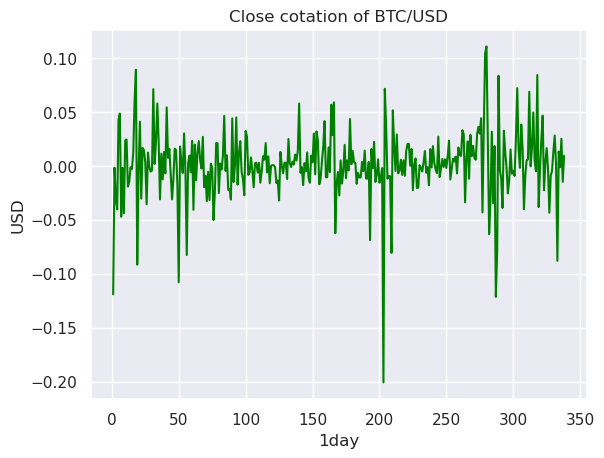

1

In [491]:
visualize_data(diff_data, symbol, interval)
d

It looks far more stationnary than the original series 

### **V-Auto-Regression and Moving Average parameters**

In this part we aim at compute the p and q parameters of our ARIMA model. 

For this sake, we might plot the **Auto Correlation Function (ACF)** and **Partial Auto Correlation Function (PACF)** plot functions. 

- **ACF** plot displays the correlation coefficients between a time series and its lag values. It explains how the present value of a given time series is related to previous values. 
- **PACF** correlates the impact on n(k) of n(k-3) that are not predicted by n(k-1) and n(k-2). 

We look for significant points outside the shaded area and a geometric decay if we are dealing with a times series where ARIMA may be appropriate.



##### **01- ACF and PACF plots**

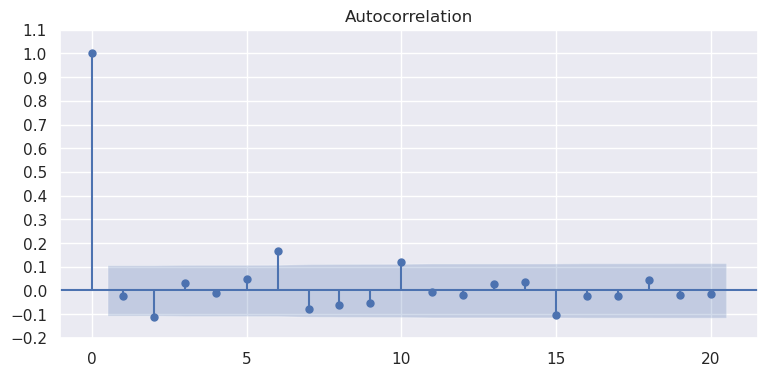

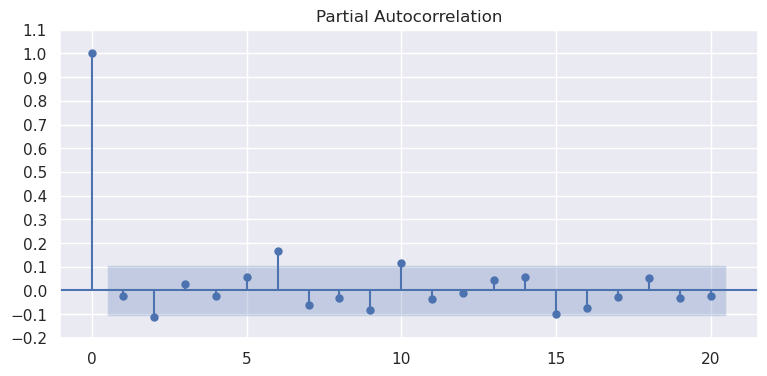

In [492]:
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools
 
def acf_pacf(data, price):
 
    fig, ax = plt.subplots(1, figsize=(9,4), dpi=100)
    sm.graphics.tsa.plot_acf(data[str(price)], lags=20, ax = ax)
    plt.ylim([-0.05, 0.25])
    plt.yticks(np.arange(-0.20,1.2, 0.1))
    plt.show()
    
    fig, ax = plt.subplots(1, figsize=(9,4), dpi=100)
    sm.graphics.tsa.plot_pacf(data[str(price)], lags = 20, ax = ax)
    plt.ylim([-0.05, 0.25])
    plt.yticks(np.arange(-0.20,1.2, 0.1))
    plt.show()


acf_pacf(diff_data, 'close')

The ACF and PACF plots, shows some significant points (ninth lag for example), but no geometric decay.

What we are seeing is likely an ARIMA(0, 1, 0) model, meaning our differenced data will be what is known as **“white noise”** and  our original data a **“random walk”** and therefore the best prediction we can do of the current is by using the precedent value.

Before moving forward, we need to check those hypothesis.


##### **02- Is our data a white noise ?**

If the variables are independent and identically distributed with a mean of zero, the time series is white noise. Let's check this possibility.

We'll proceed in two steps :

- Splitting the dataset in two parts and observe the distributions
- Compute the Ljung-box test for which H0 = Data is independently distributed.

###### **02a- SPLITTING THE DATA**

count    169.000000
mean       0.000482
std        0.028553
min       -0.119001
25%       -0.012210
50%        0.000025
75%        0.014445
max        0.088923
Name: close, dtype: float64
count    169.000000
mean       0.002424
std        0.033729
min       -0.200634
25%       -0.009206
50%        0.002512
75%        0.016393
max        0.110569
Name: close, dtype: float64


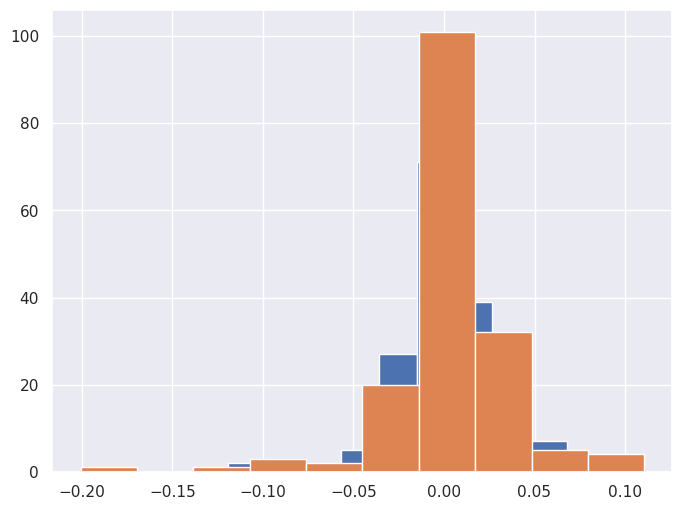

In [493]:
def fast_dist_check(data, price):
    n = int(len(data[str(price)])/2)
    print(data[str(price)][:n].describe())
    print(data[str(price)][n:].describe())

    fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)
    data[str(price)][:n].hist()
    data[str(price)][n:].hist()

fast_dist_check(diff_data, 'close')

As we can see the distribution varies quite a lot in the sample. Now we are performing the Ljung-box test

###### **02b- COMPUTING LJUNG-BOX TEST**

In [494]:
def LB_test(data, price) : 
    return sm.stats.acorr_ljungbox(data[str(price)], lags= [20], return_df= True)

LB_test(diff_data, 'close')

,lb_stat,lb_pvalue
20,30.367511,0.064114


The Ljung-box test rejects the null hypothesis

##### **03- Using Auto-ARIMA**

The function called “Auto-Arima” from the pmdarima package fit and test a selection of models and return the model with the lowest **Akaike Information Criterion (AIC)** value. 

In [508]:
def auto_arima(data, price):

    model = pm.auto_arima(data[str(price)],
                          start_p=3,
                          start_q=3,
                          test='adf',
                          max_p=15, 
                          max_q=15,
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True,
                          stepwise = True, 
                          information_criterion = 'aic')
    # difference df by d found by auto arima
    differenced_by_auto_arima = data[str(price)].diff(model.order[1])
    return model.order, differenced_by_auto_arima, model.resid()

auto_arima(data, "close")


Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1397.342, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1399.711, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1397.781, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1397.808, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1399.648, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1397.441, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.772 seconds


((0, 1, 0),
 0           NaN
 1      0.164002
 2     -0.008360
 3     -0.043394
 4      0.054110
          ...   
 347    0.013211
 348   -0.001287
 349    0.025032
 350   -0.014805
 351    0.009209
 Name: close, Length: 352, dtype: float64,
 0      5.179848
 1      0.161488
 2     -0.010875
 3     -0.045908
 4      0.051596
          ...   
 347    0.010696
 348   -0.003802
 349    0.022518
 350   -0.017319
 351    0.006695
 Length: 352, dtype: float64)

### **VI- FORECASTING FUTURE VALUES**

Since we obtained significant correlation for the ninth lag value, we will still try to predict future values with an auto-regression order and moving average of 10. 

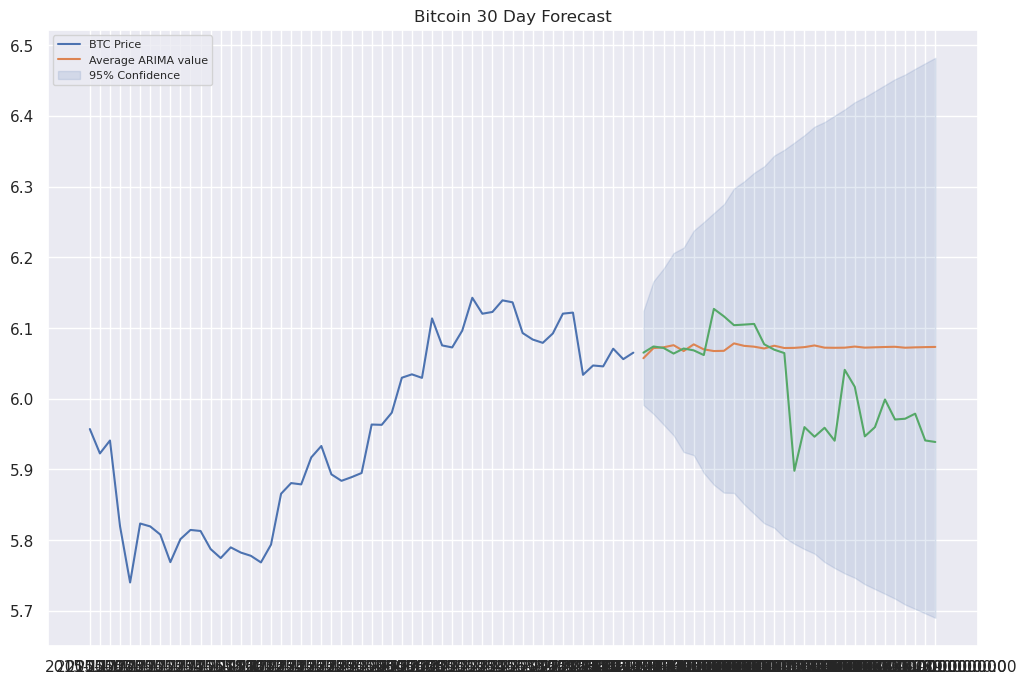

In [524]:
import datetime
import statsmodels

def model(data, price,n, p,d,q):
    """
    Parameters
    ----------
    df : TYPE
        DESCRIPTION.
    p_d_q : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    """
    
    time_series = np.log(data[str(price)])
    # fit
    model = statsmodels.tsa.arima.model.ARIMA(time_series, order = (p,d,q))
    fitted = model.fit()

    
    fc = fitted.get_forecast(n) 
    #Set confidence to 95% 
    fc = (fc.summary_frame(alpha=0.05))
    #Get mean forecast
    fc_mean = fc['mean']
    #Get lower confidence forecast
    fc_lower = fc['mean_ci_lower']
    #Get upper confidence forecast
    fc_upper = fc['mean_ci_upper'] 
    #Set figure size
    plt.figure(figsize=(12,8), dpi=100)
    #Plot last 50 price movements
    plt.plot(data['datetime'][-55:],data[str(price)][-55:], label='BTC Price')
    # create date axis for predictions
    future =  [str(datetime.datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S") + datetime.timedelta(days=x)) for x in range(n)]
    #Plot mean forecast
    plt.plot(future, np.exp(fc_mean), label='Average ARIMA value', linewidth = 1.5) 
    #Create confidence interval
    plt.fill_between(future, np.exp(fc_lower),np.exp(fc_upper), color='b', alpha=.15, label = '95% Confidence')
    #Loading and plotting the real future values
    real = load_data(symbol, end_date, future[len(future)-1], interval)
    real["close"] = np.log(real["close"])
    plt.plot(future, real["close"])
    #Set title
    plt.title(f"Bitcoin {n} Day Forecast")
    #Set legend
    plt.legend(loc='upper left', fontsize=8)
    plt.show()



model(data, "close",30, 10,1,10)

### **VII-CONCLUSIONS**

We clearly see at sight the inefficiency of the forecasting renforcing the idea of the price being indeed a random walk. 

The models fails to reproduce the sudden jumps of the price that we can observe in reality